In [68]:
def predict():

    import pickle
    import pandas as pd
    import xgboost as xgb
    from sklearn.externals import joblib

    # 데이터 불러오기
    data_for_surv_test1 = pd.read_csv('../preprocess/test1_preprocess_1.csv')
    data_for_surv_test2 = pd.read_csv('../preprocess/test2_preprocess_1.csv')

    data_for_spent_test1 =  pd.read_csv('../preprocess/test1_preprocess_2.csv')
    data_for_spent_test2 =  pd.read_csv('../preprocess/test2_preprocess_2.csv')

    # 모델 불러오기
    survival_time_model = pickle.load(open('../model/survival_time_model.pkl','rb'))
    amount_spent_model = pickle.load(open('../model/amount_spent_model.pkl','rb'))

    ## 1. 생존기간 predict
    survival_pred_test1 = survival_time_model.predict(xgb.DMatrix(data_for_surv_test1[data_for_surv_test1.columns[1:]].values))
    survival_pred_test2 = survival_time_model.predict(xgb.DMatrix(data_for_surv_test2[data_for_surv_test2.columns[1:]].values))

    # dataframe으로 만들기
    test1_predict = data_for_surv_test1[['acc_id']]
    test1_predict['survival_time'] = survival_pred_test1

    test2_predict = data_for_surv_test2[['acc_id']]
    test2_predict['survival_time'] = survival_pred_test2

    # 반올림
    test1_predict['survival_time']  = round(test1_predict['survival_time'])
    test2_predict['survival_time']  = round(test2_predict['survival_time'])

    # 0 이하는 1로. 64 이상은 64로 변경
    test1_predict['survival_time'] = test1_predict['survival_time'] - 32
    test1_predict['survival_time'] = np.where(test1_predict['survival_time']<=0, 1, np.where(test1_predict['survival_time']>=64, 64, test1_predict['survival_time']))

    test2_predict['survival_time'] = test2_predict['survival_time'] - 32
    test2_predict['survival_time'] = np.where(test2_predict['survival_time']<=0, 1, np.where(test2_predict['survival_time']>=64, 64, test2_predict['survival_time']))

    ## 2. 일평균 결제량 predict
    spent_pred_test1 = amount_spent_model.predict(xgb.DMatrix(data_for_spent_test1[data_for_spent_test1.columns[1:]].values))
    spent_pred_test2 = amount_spent_model.predict(xgb.DMatrix(data_for_spent_test2[data_for_spent_test2.columns[1:]].values))

    # 예측한 일평균결제량  컬럼 추가
    test1_predict['amount_spent'] = spent_pred_test1
    test2_predict['amount_spent'] = spent_pred_test2

    # 결제량 0 미만은 0으로 변경
    test1_predict['amount_spent'] = np.where(test1_predict['amount_spent']<0, 0,test1_predict['amount_spent'])
    test2_predict['amount_spent'] = np.where(test2_predict['amount_spent']<0, 0,test2_predict['amount_spent'])

    # predict 파일 저장
    test1_predict.to_csv('./test1_predict.csv', index=False)
    test2_predict.to_csv('./test2_predict.csv', index=False)
    return

In [70]:
predict()

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [3]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.externals import joblib
import numpy as np
    
# 전처리 데이터 불러오기
test1_preprocess = pd.read_csv('../preprocess/train_preprocess.csv')

# 필요한 컬럼만 가져오기
data_for_surv_test1 = test1_preprocess[['acc_id', 'playtime_count', 'solo_exp_count', 'quest_exp_count', 'fishing_count',
       'game_money_change_count', 'login_clt', 'deff_level', 'level_max',
       'day_count', 'char_count', 'day_sum', 'level', 'minus_am', 'plus_am',
       'num_trade_s', 'num_trade_ex', 'num_trade', 'sell_amount',
       'amount_diff', 'item_5_s_m', 'type_ex_s_m', 'trade_ratio',
       'tday_count_t', 'source_count', 'day_y', 'random_defender_cnt_y',
       'log_in_freq', 'a_server_num', 'b_server_num', 'combat_char_cnt_main',
       'combat_play_time_main', 'pledge_member_num_main',
       'pledge_member_num_sub', 'playtime_1', 'npc_kill_1', 'solo_exp_1',
       'party_exp_1', 'private_shop_1', 'playtime_2', 'npc_kill_2',
       'solo_exp_2', 'party_exp_2', 'death_2', 'fishing_2', 'playtime_3',
       'solo_exp_3', 'party_exp_3', 'private_shop_3', 'playtime_4',
       'npc_kill_4', 'solo_exp_4', 'party_exp_4', 'rich_monster_4',
       'fishing_4', 'private_shop_4', 'game_money_change_4', 'forgive_4',
       'pledge_cnt_3', 'num_opponent_4', 'play_char_cnt_1',
       'combat_char_cnt_1', 'etc_cnt_1_y', 'combat_play_time_1',
       'combat_char_cnt_2', 'pledge_combat_cnt_2', 'random_defender_cnt_2_y',
       'temp_cnt_2_y', 'combat_play_time_2', 'play_char_cnt_3',
       'combat_char_cnt_3', 'random_defender_cnt_3_y', 'temp_cnt_3_y',
       'combat_play_time_3', 'pledge_rank_3', 'combat_char_cnt_4',
       'temp_cnt_4_y', 'etc_cnt_4_y', 'combat_play_time_4', 'pledge_rank_4',
       'amount_spent_1', 'amount_spent_4']]


data_for_spent_test1 =  test1_preprocess[['acc_id','private_shop', 'random_attacker_cnt_x', 'playtime', 'quest_exp', 'fishing', 'temp_cnt_count', 'playtime_count', 'npc_kill_count', 'solo_exp_count', 'quest_exp_count', 'game_money_change_count', 'day_attack', 'day_temp', 'std_attack', 'level_max', 'day_count', 'char_max', 'day_sum', 'C_1', 'C_4', 'C_5', 'C_7', 'level', 'day_x', 'amount_spent', 'pay_count', 'pay_mean', 'pay_mean_28', 'non_login_pay', 'pluss', 'minus_am', 'plus_am', 'diff_minus', 'day_s', 'item_amount_s', 'item_price_s', 'item_3_s', 'item_5_s', 'item_6_s', 'type_ex_s', 'item_amount_t', 'item_price_t', 'item_0_t', 'item_2_t', 'item_3_t', 'item_5_t', 'item_6_t', 'type_ex_t', 'num_trade_ex', 'num_trade_shop', 'num_trade', 'sell_amount', 'buy_amount', 'margin', 'price_diff', 'amount_diff', 'day_s_m', 'item_amount_s_m', 'item_2_s_m', 'item_6_s_m', 'type_shop_s_m', 'day_t_m', 'item_price_t_m', 'item_2_t_m', 'item_3_t_m', 'type_ex_t_m', 'type_shop_t_m', 'day_s_nd', 'item_price_s_nd', 'item_6_s_nd', 'type_ex_s_nd', 'day_t_nd', 'item_amount_t_nd', 'item_price_t_nd', 'item_1_t_nd', 'item_2_t_nd', 'item_3_t_nd', 'trade_ratio', 'tday_count_s', 'tday_mean_s', 'tday_count_t', 'hour_s', 'hour_mean', 'hour_s_100', 'hour_s_200', 'hour_s_500', 'hour_s_700', 'hour_s_800', 'hour_t_100', 'hour_t_300', 'source_merchant_ratio', 'day_y', 'play_char_cnt', 'pledge_combat_cnt', 'same_pledge_cnt_y', 'temp_cnt_y', 'pledge_member_num', 'play_char_cnt_main', 'combat_char_cnt_main', 'play_char_cnt_sub', 'pledge_combat_cnt_sub', 'same_pledge_cnt_sub', 'solo_exp_1', 'quest_exp_1', 'game_money_change_1', 'playtime_2', 'quest_exp_2', 'playtime_3', 'playtime_4', 'quest_exp_4', 'game_money_change_4', 'same_pledge_cnt_1_x', 'etc_cnt_1_x', 'num_opponent_1', 'play_char_cnt_1', 'same_pledge_cnt_1_y', 'temp_cnt_1_y', 'etc_cnt_1_y', 'combat_play_time_1', 'pledge_rank_1', 'play_char_cnt_2', 'combat_char_cnt_2', 'play_char_cnt_3', 'combat_char_cnt_3', 'random_attacker_cnt_3_y', 'same_pledge_cnt_3_y', 'temp_cnt_3_y', 'etc_cnt_3_y', 'combat_play_time_3', 'play_char_cnt_4', 'temp_cnt_4_y', 'combat_play_time_4', 'pledge_rank_4', 'amount_spent_1', 'amount_spent_3', 'amount_spent_4', 'week1_log', 'week3_log', 'week4_log' ]]

    
# 모델 불러오기
survival_time_model = pickle.load(open('../model/survival_time_model.pkl','rb'))
amount_spent_model = pickle.load(open('../model/amount_spent_model.pkl','rb'))

## 1. 생존기간 predict
survival_pred_test1 = survival_time_model.predict(xgb.DMatrix(data_for_surv_test1[data_for_surv_test1.columns[1:]].values))


# dataframe으로 만들기
test1_predict = data_for_surv_test1[['acc_id']]
test1_predict['survival_time'] = survival_pred_test1


# 반올림
test1_predict['survival_time']  = round(test1_predict['survival_time'])


# 0 이하는 1로. 64 이상은 64로 변경
test1_predict['survival_time'] = test1_predict['survival_time'] - 32
test1_predict['survival_time'] = np.where(test1_predict['survival_time']<=0, 1, np.where(test1_predict['survival_time']>=64, 64, test1_predict['survival_time']))


## 2. 일평균 결제량 predict
spent_pred_test1 = amount_spent_model.predict(xgb.DMatrix(data_for_spent_test1[data_for_spent_test1.columns[1:]].values))


# 예측한 일평균결제량  컬럼 추가
test1_predict['amount_spent'] = spent_pred_test1


# 결제량 0 미만은 0으로 변경
test1_predict['amount_spent'] = np.where(test1_predict['amount_spent']<0, 0,test1_predict['amount_spent'])


# predict 파일 저장
test1_predict.to_csv('./test1_predict.csv', index=False)


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [6]:
from score_function import score_function 

In [7]:
score_function('./test1_predict.csv','../raw/train_label.csv')

37696.27621591419


(37696.27621591419,
 [0.0,
  -0.022409891999999997,
  0.0,
  0.0,
  -0.065966919,
  0.0,
  0.36530255538669704,
  -0.0227547795,
  -2.5414432499999995,
  -0.34637504999999996,
  0.0,
  0.0,
  -0.0016961013512552699,
  0.0,
  1.3448835469556661,
  1.8035109229220008,
  0.0,
  0.4366597330953514,
  0.0,
  0.0,
  -0.0948642,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.030182754,
  0.0,
  0.0,
  -0.036816279,
  0.0,
  -0.029439532799999994,
  -0.36077064000000003,
  -0.017977104,
  -0.022020569999999996,
  0.0,
  0.4246862858052264,
  -0.049961910000000005,
  -0.026154710999999997,
  -0.29427543,
  0.0,
  1.4265670385651459,
  0.0,
  -0.017027244,
  -0.03800983808040579,
  1.0385685545977748,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.0178035558,
  -0.10048573200000001,
  0.0,
  0.0,
  4.40785520188382,
  -0.31629162766876895,
  -0.024409773,
  0.44890794980109333,
  -0.013867181999999999,
  0.0,
  0.0,
  -0.09200756399999999,
  19.754814372025585,
  -0.017865354,
  -0.0061282574999999995,
  0.78

In [9]:
test1_predict[test1_predict['amount_spent']>30]

,acc_id,survival_time,amount_spent
6994,23120,1.0,31.201746
15446,50670,1.0,37.674534
24506,79872,1.0,36.772312
28988,94454,1.0,37.683605
31997,104223,1.0,32.056335


In [20]:
test1_predict[test1_predict['acc_id']==79872]

,acc_id,survival_time,amount_spent
24506,79872,1.0,36.772312


In [16]:
train_label=pd.read_csv('../raw/train_label.csv')
train_label[train_label['amount_spent']>30]

,acc_id,survival_time,amount_spent
13903,30688,1,35.949426
23912,102496,1,39.412632
27235,65542,1,31.252524
30498,79872,1,32.214971


In [21]:
test1_predict

,acc_id,survival_time,amount_spent
0,2,64.0,0.020268
1,5,16.0,0.074700
2,8,64.0,0.068250
3,17,64.0,0.057134
4,20,43.0,0.219890
5,21,64.0,0.082332
6,31,20.0,0.061913
7,38,38.0,0.075849
8,41,1.0,8.471478
9,43,20.0,1.154583


In [23]:
train_label.sort_values('acc_id')

,acc_id,survival_time,amount_spent
22410,2,64,0.000000
12651,5,60,0.000000
5494,8,64,0.020310
6811,17,64,0.070642
16854,20,64,0.052137
38362,21,64,0.184267
15073,31,45,0.051316
1057,38,64,0.517168
29395,41,3,0.000000
27090,43,64,0.356197


In [24]:
sc = pd.merge(test1_predict, train_label, on ='acc_id')

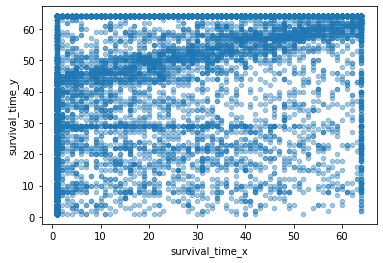

In [27]:
sc.plot(kind='scatter', x='survival_time_x', y= 'survival_time_y', alpha=0.4)

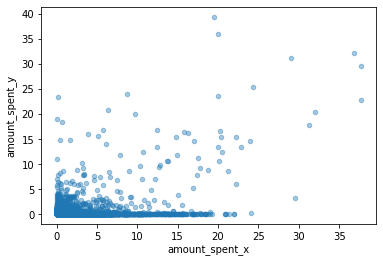

In [29]:
sc.plot(kind='scatter', x='amount_spent_x', y= 'amount_spent_y', alpha=0.4)

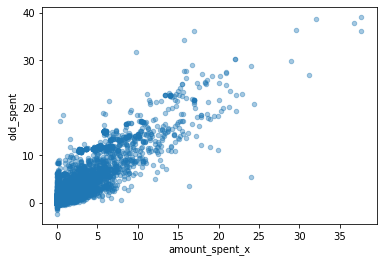

In [56]:
sc.plot(kind='scatter', x='amount_spent_x', y= 'old_spent', alpha=0.4)

In [32]:
select1  =  pickle.load(open('./select_w1_5_12000score_1_2_mean.pkl','rb'))
model2  =  pickle.load(open('./xgb_w1_5_12000score_1_2_mean.pkl','rb'))


[09:32:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator SelectFromModel from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [35]:
test1_preprocess.head()

,acc_id,temp_cnt_x,private_shop,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,num_opponent,...,combat_play_time_4,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4,week1_log,week2_log,week3_log,week4_log
0,2,0.000000,84.900753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000
1,5,0.479728,0.000000,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,0.098129,...,3.661882,66814.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.142857
2,8,3.837822,0.000000,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,1.864446,...,29.782361,22331.0,1.056123,0.000000,0.000000,0.348521,1.0,1.0,1.000000,1.000000
3,17,3.358094,0.000000,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,1.275674,...,15.140507,2673.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000
4,20,0.959456,2.917510,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,13.934283,...,18.448062,2500.0,0.000000,0.070408,0.826123,0.000000,1.0,1.0,1.000000,1.000000


In [33]:
s1 = select1.transform(test1_preprocess)

In [34]:
dtest = xgb.DMatrix(s1)
re1 = model2.predict(dtest)

In [36]:
re1

array([0.0551779 , 0.03835753, 0.8361083 , ..., 0.30432537, 0.8487617 ,
       0.66306376], dtype=float32)

In [37]:
sc['old_spent'] = re1

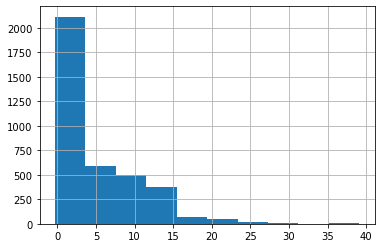

In [55]:
sc[sc['amount_spent_x']>=1]['old_spent'].hist()

In [41]:
k = sc[['acc_id','survival_time_x','old_spent']]
k = k.rename(columns={'survival_time_x':'survival_time', 'old_spent':'amount_spent'})

In [44]:
k.to_csv('./old_test.csv', index=False)

In [45]:
score_function('./old_test.csv','../raw/train_label.csv')

47365.95028613686


(47365.95028613686,
 [0.0,
  -0.0115072578,
  0.0,
  0.0,
  -0.33807363000000007,
  0.0,
  0.25574528418669706,
  -0.11178313499999999,
  -4.1611712999999995,
  -0.15797147999999997,
  0.0,
  0.0,
  -0.1439416298297886,
  0.0,
  8.945017907988163,
  1.7360397814220008,
  0.0,
  0.07662145699535139,
  0.0,
  0.0,
  -0.14980053,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.23554659000000003,
  0.0,
  0.0,
  -0.23949515999999998,
  0.0,
  -0.295965,
  -0.9312598799999999,
  -0.174883728,
  -0.137168286,
  0.0,
  0.35933791580522634,
  -0.071475069,
  -0.264578139,
  -2.4923510999999996,
  0.0,
  1.326242736565146,
  0.0,
  -0.14598577799999998,
  -0.2108945070804058,
  1.0257427505977748,
  0.0,
  0.0,
  0.0,
  0.0,
  0.028295606999999997,
  -0.13470015,
  -0.19379364658005444,
  0.0,
  3.89252708188382,
  -0.4360394476687689,
  -0.37469436,
  1.8319796020721837,
  -0.05582009699999999,
  0.0,
  0.0,
  -0.37328210999999994,
  19.480828872025587,
  -0.4525278,
  0.0031536161999999998,
  

In [ ]:
# 

가중치 적용 라벨 rmse:  3.7879211702697564
Thresh=0.94*mean, n=141,  rmse: 1.187327
    
가중치 적용 라벨 rmse:  3.7992352026295313
Thresh=0.96*mean, n=139,  rmse: 1.168062
    
가중치 적용 라벨 rmse:  3.7734948184415207
Thresh=0.97*mean, n=137,  rmse: 1.185000
    
가중치 적용 라벨 rmse:  3.7723843409307887
Thresh=0.98*mean, n=136,  rmse: 1.183573